# Test experimental code on datasets

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental')

In [3]:
from data import DataBuilder
from solver import DualSolver

In [4]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/tests')

In [5]:
from conftest import *

In [6]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking')

In [7]:
from run_raking import run_raking

# USHD example

Current version of the code.

In [8]:
example_USHD = ExampleUSHD()

In [9]:
(df_raked, Dphi_y, Dphi_s, sigma) = run_raking(
    dim='USHD',
    df_obs=example_USHD.df_obs,
    df_margins=[example_USHD.df_margins],
    var_names=None,
    method='entropic',
    cov_mat=False)

Check if margins are respected.

In [10]:
sum_over_race_county = (
    df_raked.loc[df_raked.race != 0].groupby(['cause'])
    .agg({'raked_value': 'sum'})
    .reset_index()
    .merge(example_USHD.df_margins, on=['cause'])
    )
np.allclose(
    sum_over_race_county['raked_value'],
    sum_over_race_county['value_agg_over_race_county'],
    atol=1.0e-5,
)

True

Rename values for merging with experimental results.

In [11]:
df_raked.replace({'cause': '_all', 'race': 0}, -1, inplace=True)
df_raked.drop(columns=['upper'], inplace=True)
df_raked.replace({'cause': {'_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

Experimental version of the code.

In [12]:
example_USHD = ExampleUSHD()

In [13]:
df_obs = example_USHD.df_obs
df_obs['weights'] = 1.0
df_obs.replace({'cause': '_all', 'race': 0}, -1, inplace=True)
df_obs.drop(columns=['upper'], inplace=True)
df_obs.replace({'cause': {'_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

In [14]:
df_margin = example_USHD.df_margins
df_margin['race'] = -1
df_margin['county'] = -1
df_margin['weights'] = np.inf
df_margin.rename(columns={'value_agg_over_race_county': 'value'}, inplace=True)
df_margin.replace({'cause': {'_all': -1, '_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

In [15]:
df = pd.concat([df_obs, df_margin])

In [16]:
df = df.astype({'cause': 'int64'})

In [17]:
data_builder = DataBuilder(
    dim_specs={'cause': -1, 'race': -1, 'county': -1},
    value='value',
    weights='weights'
)

In [18]:
data = data_builder.build(df)

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:230: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


In [19]:
solver = DualSolver(distance='entropic', data=data)

In [20]:
df_exp = solver.solve()

In [21]:
solver.result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -574.3099097037687
       x: [ 7.732e+00  2.574e+00 ... -5.760e+00 -1.281e+01]
     nit: 17
     jac: [ 1.057e-07  4.401e-06 ... -1.427e-06 -1.540e-06]
    nfev: 22
    njev: 22
    nhev: 17

Check if margins are respected.

In [22]:
sum_over_race_county = (
    df_exp.groupby(['cause'])
    .agg({'soln': 'sum'})
    .reset_index()
    .merge(df_margin, on=['cause'])
    )
np.allclose(
    sum_over_race_county['soln'],
    sum_over_race_county['value'],
    atol=1.0e-5,
)

True

Add partial sums to dataset.

In [23]:
sum_over_cause = (
    df_exp.groupby(['race', 'county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_cause['cause'] = -1

In [24]:
sum_over_race = (
    df_exp.groupby(['cause', 'county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_race['race'] = -1

In [25]:
sum_over_cause_race = (
    df_exp.groupby(['county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_cause_race['cause'] = -1
sum_over_cause_race['race'] = -1

In [26]:
df_exp = pd.concat([df_exp, sum_over_cause, sum_over_race, sum_over_cause_race])

Create data frame for plotting.

In [27]:
df_raked['version'] = 'current'
df_exp['version'] = 'experimental'

In [28]:
df_exp = df_exp.merge(df, how='inner', on=['cause', 'race', 'county'])
df_exp = df_exp.drop(columns=['weights']).rename(columns={'soln': 'raked_value'})

In [29]:
df_comp = pd.concat([df_raked, df_exp])

Plot.

In [30]:
min_value = min(df_comp['raked_value'].min(), df_comp['value'].min())
max_value = max(df_comp['raked_value'].max(), df_comp['value'].max())

x1, x2 = alt.param(value=min_value), alt.param(value=max_value)
y1, y2 = alt.param(value=min_value), alt.param(value=max_value)
line = alt.Chart().mark_rule(color='grey').encode(
    x=alt.datum(x1, type='quantitative'),
    x2=alt.datum(x2, type='quantitative'),
    y=alt.datum(y1, type='quantitative'),
    y2=alt.datum(y2, type='quantitative')
).add_params(x1, x2, y1, y2)

mx = alt.Chart().mark_point(size=80, filled=True).encode(
        x=alt.X('value:Q', axis=alt.Axis(title='Observations'), scale=alt.Scale(domain=[x1, x2])),
        y=alt.Y('raked_value:Q', axis=alt.Axis(title='Raked values'), scale=alt.Scale(domain=[y1, y2])),
        color=alt.Color('version:N', legend=alt.Legend(title='Version')),
        shape=alt.Shape('version:N', legend=alt.Legend(title='Version'))
    )
chart = alt.layer(line, mx, data=df_comp).configure_axis(
        labelFontSize=18,
        titleFontSize=18
    ).configure_legend(
        labelFontSize=12,
        titleFontSize=12
    )

In [31]:
chart

alt.LayerChart(...)

In [32]:
chart.save("comparison.png")

Sort values and compare.

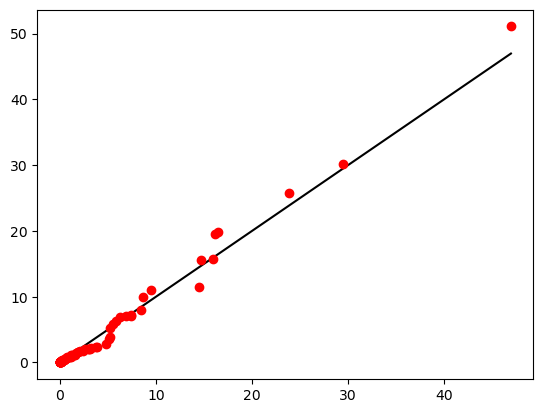

In [42]:
current = df_raked.raked_value.to_numpy()
current.sort()
experimental = df_exp.raked_value.to_numpy()
experimental.sort()
plt.plot(current, current, 'k-')
plt.plot(current, experimental, 'ro')